In [1]:
%pylab inline
from pathlib import Path

import numpy as np
import time
import tqdm
import torch
import shutil
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, RandomResizedCrop, RandomVerticalFlip, RandomHorizontalFlip
from torchvision.transforms import ColorJitter, ToTensor, Normalize


FRUIT360_PATH = Path(".").resolve().parent / "input" / "fruits-360_dataset" / "fruits-360"

img_size = 64

device = "cuda"
if not torch.cuda.is_available():
    device = "cpu"

train_transform = Compose([
    RandomHorizontalFlip(),    
    RandomResizedCrop(size=img_size),
    ColorJitter(brightness=0.12),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = Compose([
    RandomResizedCrop(size=img_size),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

batch_size = 128
num_workers = 10

train_dataset = ImageFolder((FRUIT360_PATH /"Training").as_posix(), transform=train_transform, target_transform=None)
val_dataset = ImageFolder((FRUIT360_PATH /"Test").as_posix(), transform=val_transform, target_transform=None)

pin_memory = "cuda" in device
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                          drop_last=True, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
                        drop_last=False, pin_memory=pin_memory)


Populating the interactive namespace from numpy and matplotlib


In [2]:
b = iter(val_loader).next()

In [3]:
data, labels = b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0,60,'Tomato 1')

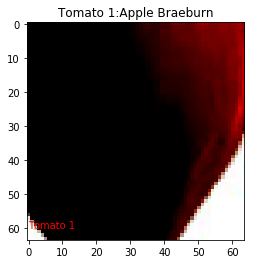

In [4]:
imshow(data[0].numpy().transpose(1, 2, 0))
predictions=[0]*len(labels)
title("{}:{}".format(val_dataset.classes[labels[0]], val_dataset.classes[predictions[0]]));
text(0, 60, val_dataset.classes[labels[0]], color='r')

In [5]:
def show_batch(images, targets, predictions=None):
    ncols = 5
    nrows = 5
    for i in range(25):
        subplot(nrows, ncols, i+1)
        imshow(data[i].numpy().transpose())
        text(0, 60, val_dataset.classes[labels[i]], color='brown')
        if predictions is not None:
            xlabel("P:{}, T:{}".format( predictions[i].numpy(), targets[i].numpy()), fontsize='70')
        elif targets is not None:
            xlabel("T:{}".format(targets[i].numpy()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

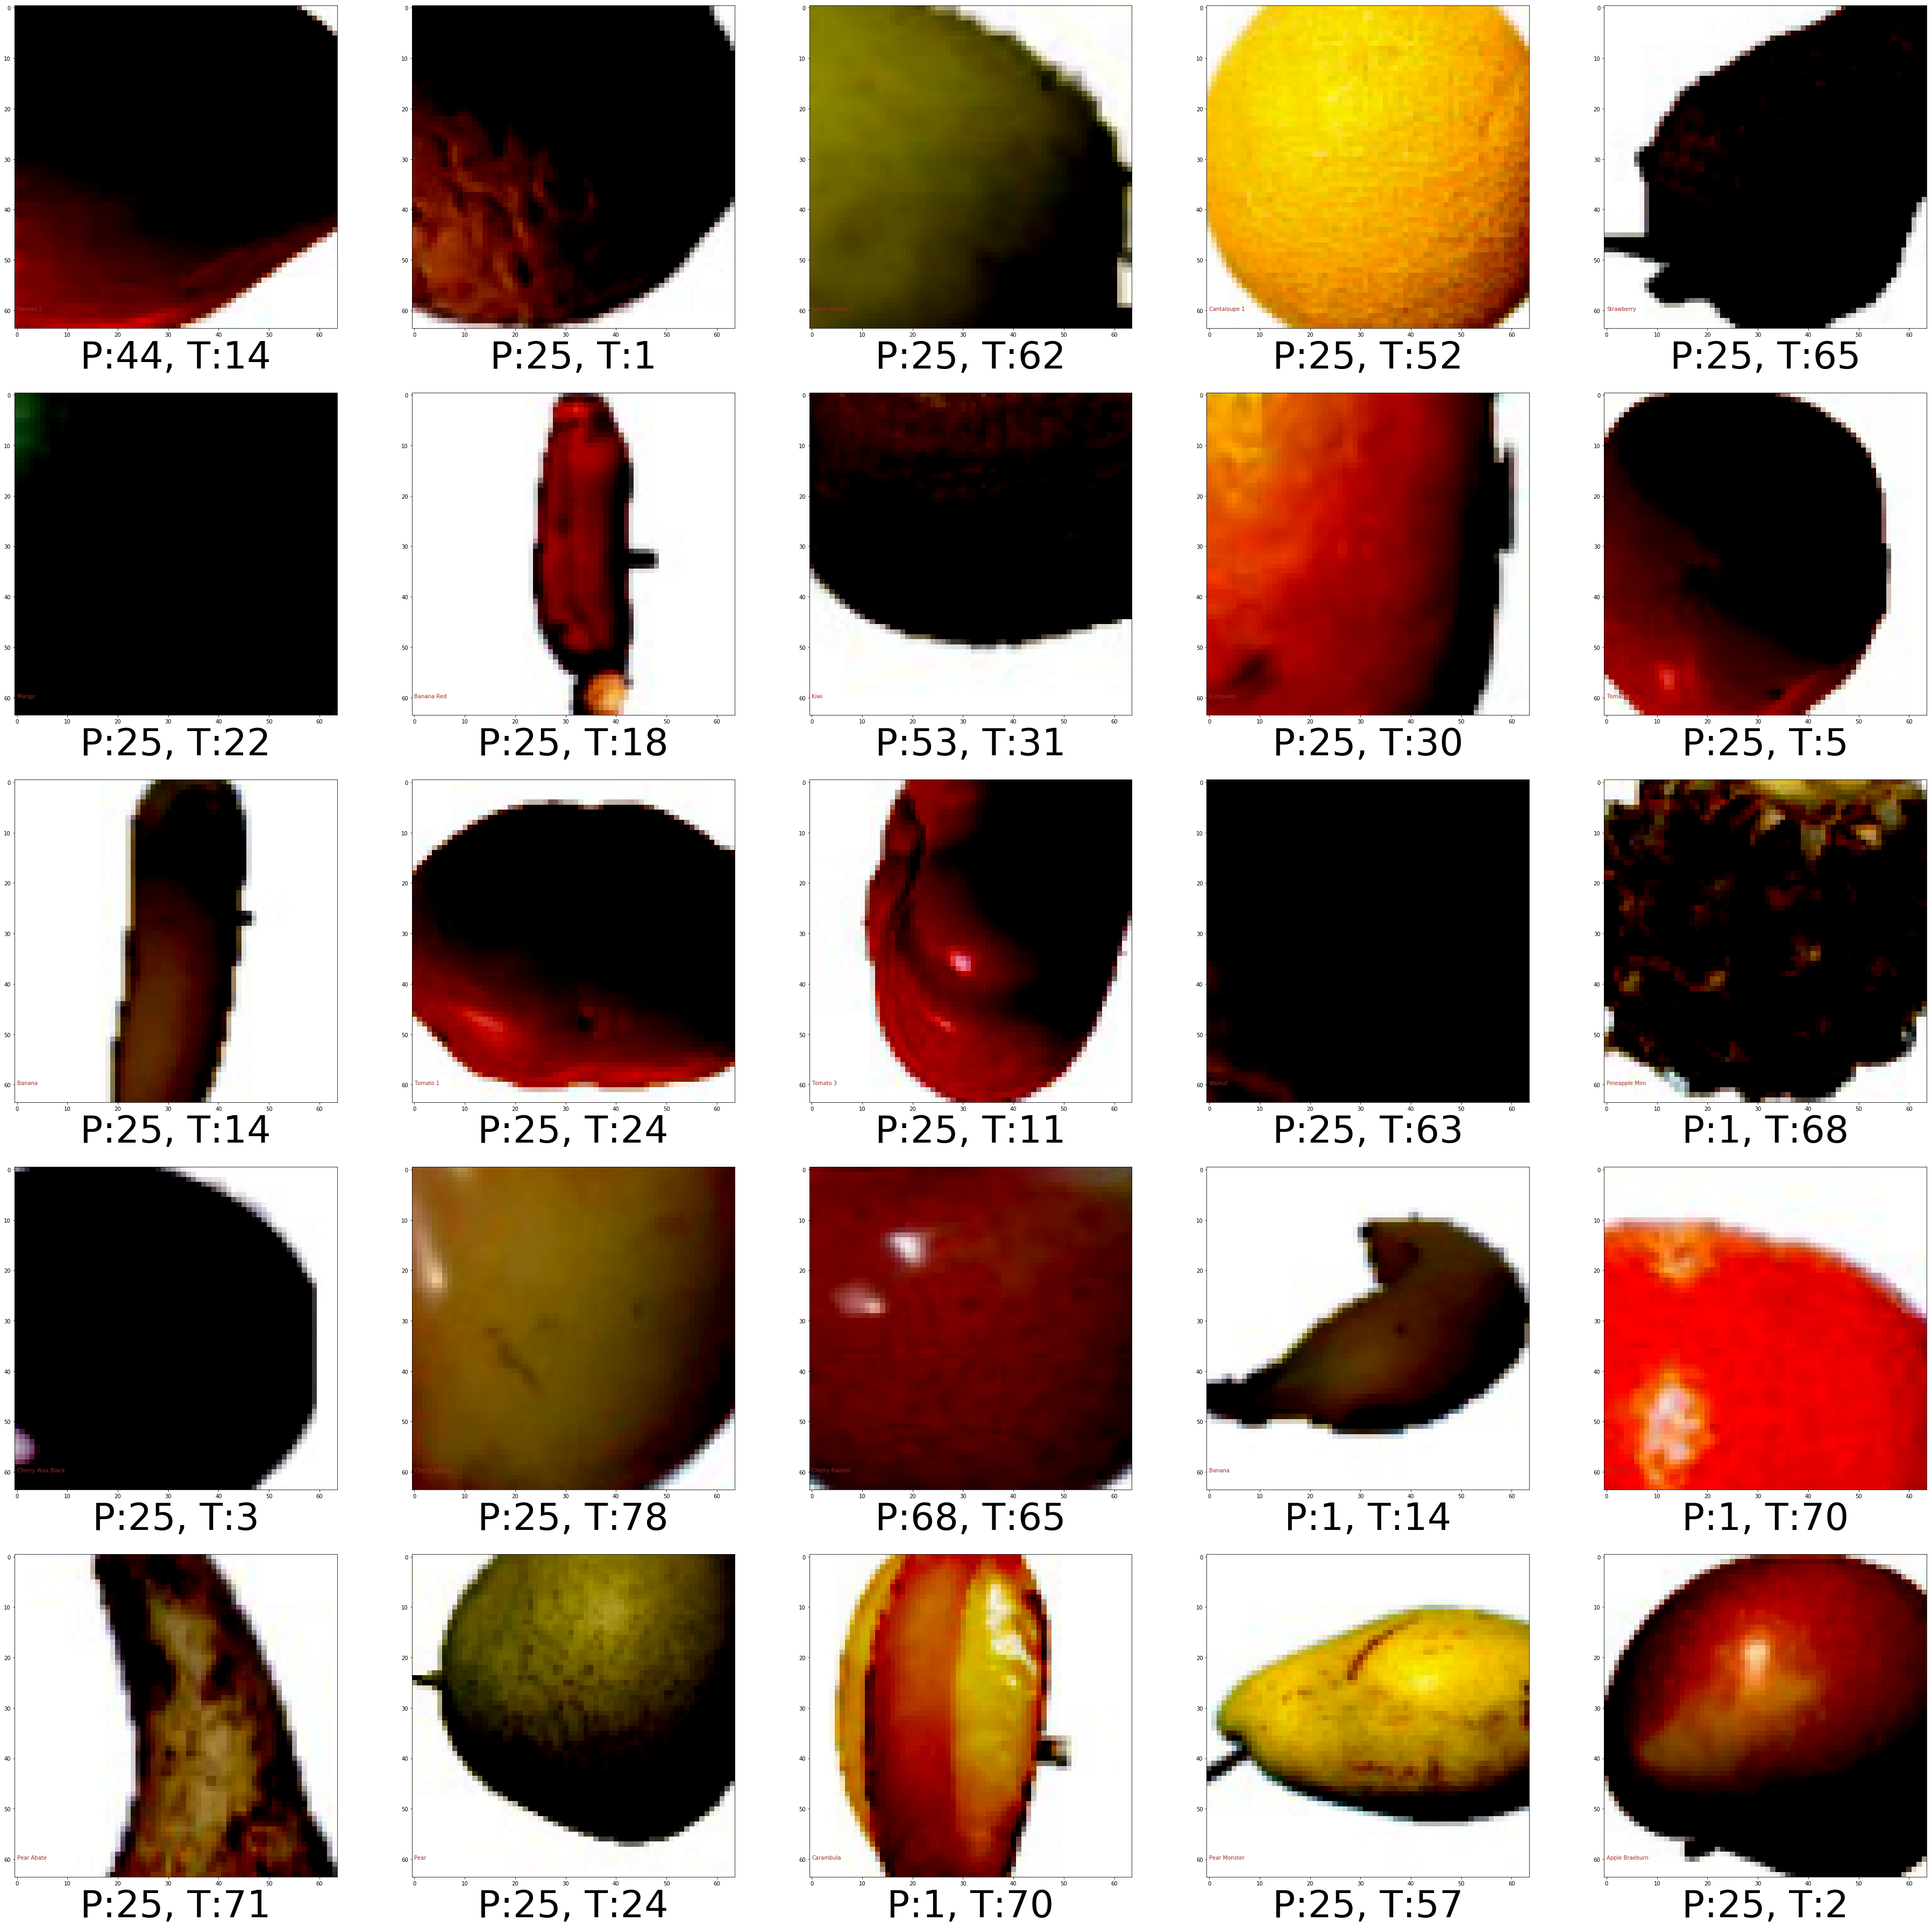

In [11]:
figsize(64,64)
eval_data, eval_target = iter(val_loader).next()
show_batch(eval_data, eval_target, model(eval_data.cuda()).cpu().detach().argmax(1))

In [7]:
print("PyTorch version: {} | Device: {}".format(torch.__version__, device))
print("Train loader: num_batches={} | num_samples={}".format(len(train_loader), len(train_loader.sampler)))
print("Validation loader: num_batches={} | num_samples={}".format(len(val_loader), len(val_loader.sampler)))

PyTorch version: 0.4.1 | Device: cuda
Train loader: num_batches=322 | num_samples=41322
Validation loader: num_batches=109 | num_samples=13877


In [8]:
import torch.nn as nn
from torchvision.models.squeezenet import squeezenet1_1
from torch.optim import SGD


In [9]:
model = squeezenet1_1(pretrained=False, num_classes=81)
model.classifier[-1] = nn.AdaptiveAvgPool2d(1)
model = model.to(device)

C:\Users\zjd19\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\zjd19\Anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [10]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

In [12]:
start_epoch = 0
num_epochs = 30
best_epoch = 0
best_eval_loss = float('inf')

In [13]:
def compute_eval_loss(net, loader):
    # Evaluate the model
    with torch.no_grad():
        eval_loss = 0.0
        for i, data in tqdm.tqdm(enumerate(loader),
                                 file = sys.stdout,
                                 desc='Evaluating',
                                 total=len(loader),
                                 leave=False):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)               # Predict
            loss = criterion(outputs, labels)   # Grade / Evaluate
            eval_loss += loss.item()
    eval_loss /= len(val_loader)
    return eval_loss

In [14]:
for epoch in tqdm.tnrange(start_epoch, num_epochs):
    
    running_loss = 0.0
    tstart = time.time()
    
    # Update the model parameters
    for i, data in tqdm.tqdm(enumerate(train_loader), 
                             file = sys.stdout,
                             desc='Updating',
                             total=len(train_loader), 
                             leave=False):
        # get the inputs
        inputs, labels = data
        
        # Move them to the GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)               # Predict
        loss = criterion(outputs, labels)   # Grade / Evaluate
        loss.backward()                     # Determine how each parameter effected the loss
        optimizer.step()                    # Update parameters 

        # print statistics
        running_loss += loss.item()
    running_loss /= len(train_loader)
    

    eval_loss = compute_eval_loss(model, val_loader)
    
    tend = time.time()
    
    # Save parameters
    torch.save(dict(epoch=epoch, 
                         loss=eval_loss,
                         parameters=model.state_dict(),
                         optimizer=optimizer.state_dict()),
                   'simplecnn-checkpoint.pth.tar')
    
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_epoch = epoch
        shutil.copyfile('simplecnn-checkpoint.pth.tar', 'simplecnn-best.pth.tar')
        
    print("Epoch {: 4}   loss: {: 2.5f}  test-loss: {: 2.5}  time: {}".format(epoch,
                                                                                running_loss,
                                                                                eval_loss,
                                                                                tend-tstart))

Epoch    0   loss:  4.00542  test-loss:  3.219  time: 56.593670129776                                                  
Epoch    1   loss:  2.90226  test-loss:  2.2719  time: 59.52185583114624                                               
Epoch    2   loss:  2.17476  test-loss:  1.5818  time: 64.50362730026245                                               
Epoch    3   loss:  1.63691  test-loss:  1.1107  time: 57.81350302696228                                               
Epoch    4   loss:  1.28142  test-loss:  0.89338  time: 58.70806813240051                                              
Epoch    5   loss:  1.06084  test-loss:  0.81451  time: 56.68940043449402                                              
Epoch    6   loss:  0.86854  test-loss:  0.82797  time: 59.262606143951416                                             
Epoch    7   loss:  0.74586  test-loss:  0.79867  time: 60.84961938858032                                              
Epoch    8   loss:  0.65097  test-loss: 

In [15]:
predictions = np.zeros(len(val_dataset))
targets = np.zeros(len(val_dataset))

for i  in tqdm.tnrange(len(val_dataset)):
    x, t = val_dataset[i]
    p = model(x[None,...].cuda()).cpu().argmax(1)[0]
    predictions[i] = int(p)
    targets[i] = t

In [16]:
print(classification_report(targets, predictions, digits=3))

C:\Users\zjd19\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0      0.612     0.433     0.507       164
        1.0      0.988     0.994     0.991       164
        2.0      0.936     0.988     0.961       164
        3.0      0.961     0.615     0.750       161
        4.0      0.994     0.945     0.969       164
        5.0      0.450     0.915     0.604       164
        6.0      0.673     0.805     0.733       164
        7.0      0.841     0.806     0.823       144
        8.0      0.926     0.976     0.950       166
        9.0      0.689     0.768     0.726       164
       10.0      0.976     0.738     0.840       164
       11.0      0.973     1.000     0.986       143
       12.0      0.976     1.000     0.988       166
       13.0      0.825     0.994     0.902       166
       14.0      0.948     0.886     0.916       166
       15.0      0.918     0.940     0.929       166
       16.0      0.987     0.933     0.959       164
       17.0      0.953     0.994     0.973   

TypeError: Invalid dimensions for image data

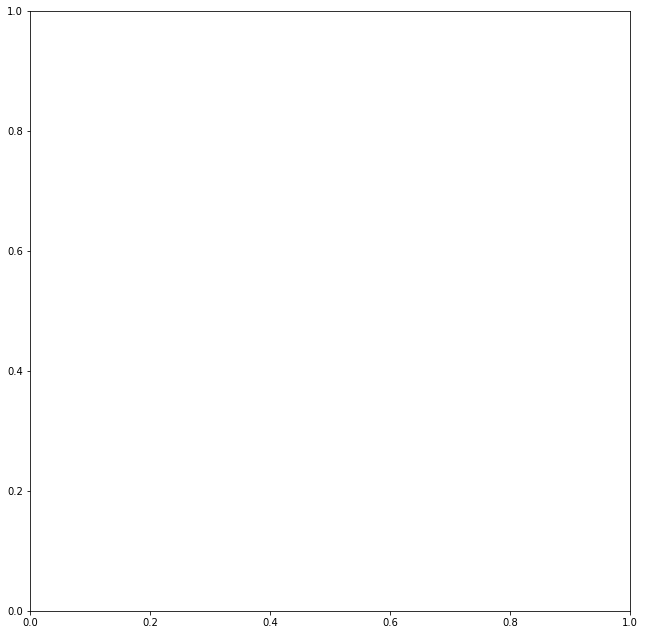

In [20]:
figsize(64,64)
eval_data, eval_target = iter(val_loader).next()
show_batch(eval_data, eval_target, model(eval_data.cuda()).cpu().detach().argmax(1))

In [18]:
with torch.no_grad():
    cm = np.zeros((81,81), dtype=np.int64)
    for x, y in iter(val_loader):
        p = model(x.cuda()).cpu().argmax(1).numpy()
        for pred, true in zip(p, y):
            cm[int(pred), int(true)] += 1

Text(0.5,42,'true')

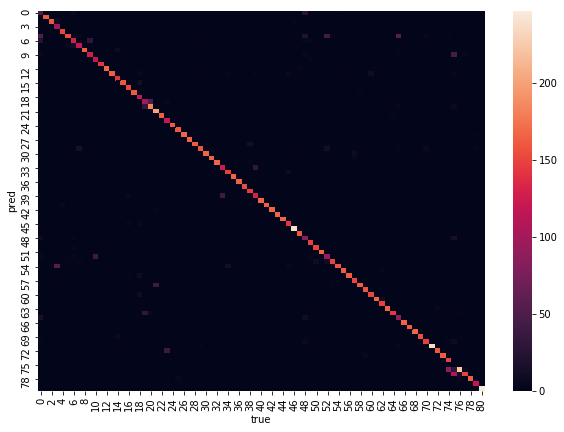

In [19]:
import pandas as pd
import seaborn as sn
df_cm = pd.DataFrame(cm, index = arange(81), columns = arange(81))
figure(figsize = (10,7))
sn.heatmap(df_cm, fmt='d', annot=False);
ylabel('pred')
xlabel('true')